# FNC Model aplicado ao Lançamento de Projétil

Esse notebook contém o modelo de rede neural FNC (Fully Convolutional Network) aplicado ao lançamento de um projétil
## Overview

Considere que o vetor posição é de tal forma que
$$
    \vec{r}(t) = (r_{x}(t), r_{y}(t))
$$

Onde a velocidade é dada por:

$$
    \vec{v}(t) = \left(\dfrac{dr_{x}}{dt}, \dfrac{dr_{y}}{dt}\right)
$$

A equação diferencial que governa o problema, é dada por:
$$
-\mu \left|\dfrac{d\vec{r}}{dt}\right|\dfrac{d\vec{r}}{dt} -\vec{g} - \dfrac{d^{2}\vec{r}}{dt^{2}} = 0
$$

Onde $\mu$ é um coeficiente de arraste normalizado pela massa.

# Import modules

In [15]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt

# Define util functions

In [16]:
def saveGif(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def plotResult(x, y, x_data, y_data, labelY, labelY_data, title, fileName, yLimInf = -1, yLimSup = 1):
    plt.style.use('default')
    fig1 = plt.figure(figsize=(8,6))
    axes = fig1.add_axes([0.1,0.1,0.8,0.8])

    axes.plot(x, y, label=labelY)

    if(len(x_data) & len(y_data)):
        axes.scatter(x_data, y_data, color="tab:orange", label=labelY_data)
    
    axes.set_xlabel('x coordinate')
    axes.set_ylabel('y coordinate')

    axes.set_title(title)
    # plt.ylim([yLimInf, yLimSup])
    plt.legend()
    plt.grid(linestyle='-', linewidth=0.5)
    plt.savefig(fileName, dpi=400)


def plotPrettyResult(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Physical training data')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    # plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,1.0,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

# Define Runge-Kutta methods

In [17]:
def f(t, v, g, m, k):
    kmv = np.linalg.norm(v)*(k/m)
    return (g - kmv*v)

def RK4(tn, rn, vn, h, g, m, k):

    k1v = f(tn, vn, g, m, k)
    k2v = f(tn + h/2, vn + k1v*h/2, g, m, k)
    k3v = f(tn + h/2, vn + k2v*h/2, g, m, k)
    k4v = f(tn + h, vn + k3v*h, g, m, k)
    vn1 = vn + (k1v + 2*k2v + 2*k3v + k4v)*(h/6)

    k1r = vn
    k2r = vn + k1v*h/2
    k3r = vn + k2v*h/2
    k4r = vn + k3v*h
    rn1 = rn + (k1r + 2*k2r + 2*k3r + k4r)*(h/6)
    # xn1 = xn + vn*h + (k1v+k2v+k3v)*h**2/6

    return vn1, rn1

In [18]:
theta = np.radians(30)
v0 = np.array([8*np.cos(theta), 8*np.sin(theta)])
r0 = np.array([0, 0])
t0 = 0
r = []
v = [] 
t = []
r.append(r0)
v.append(v0)
t.append(t0)

m = 1
k = 0.001
g = np.array([0, -9.81])
h = 0.001

tn = t0
vn = v0
rn = r0
maxt = 1

while (tn < maxt):
   vn, rn = RK4(tn, rn, vn, h, g, m, k)
   tn = tn + h
   t.append(tn)
   r.append(rn)
   v.append(vn)

In [19]:
def parametricCoordinates(r):

    x = []
    y = []

    for position in r:
        x.append(position[0])
        y.append(position[1])

    return x, y

## Plot solutions

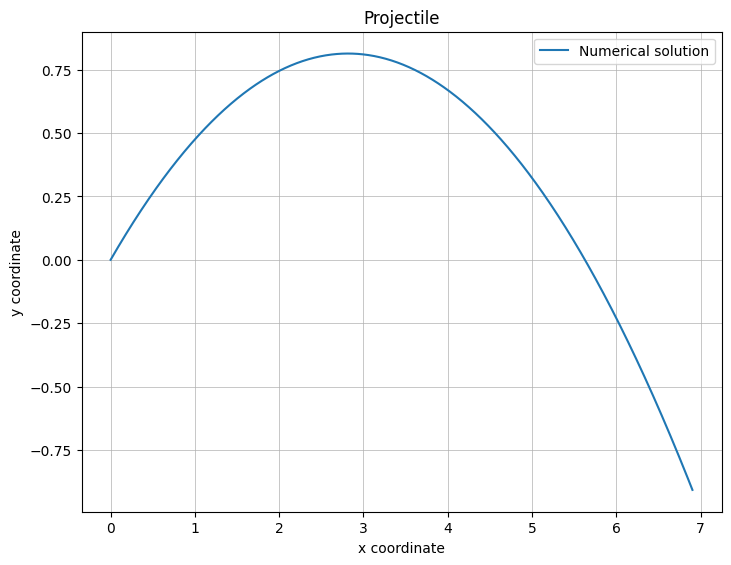

In [20]:
x, y = parametricCoordinates(r)

plotResult(x, y, [], [], 'Numerical solution', 'Training data', 'Projectile', 'plots/projectile1.png')

# Define FNC

In [21]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### Generating data for training

In [22]:
x_data = x[0:400:40]
y_data = y[0:400:40]

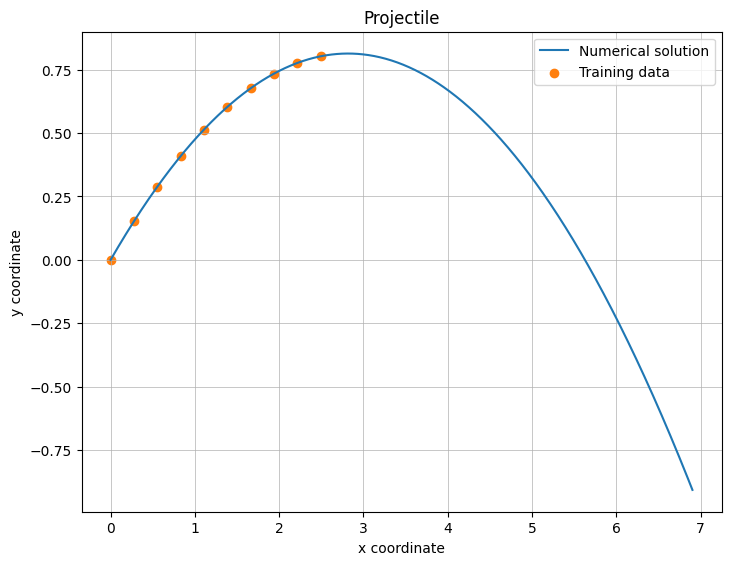

In [23]:
plotResult(x, y, x_data, y_data, 'Numerical solution', 'Training data', 'Projectile', 'plots/projectileTraining1.png')

### Training the standard neural network

tensor([[0.0000],
        [0.2771],
        [0.5541],
        [0.8310],
        [1.1078],
        [1.3846],
        [1.6612],
        [1.9378],
        [2.2143],
        [2.4908]])


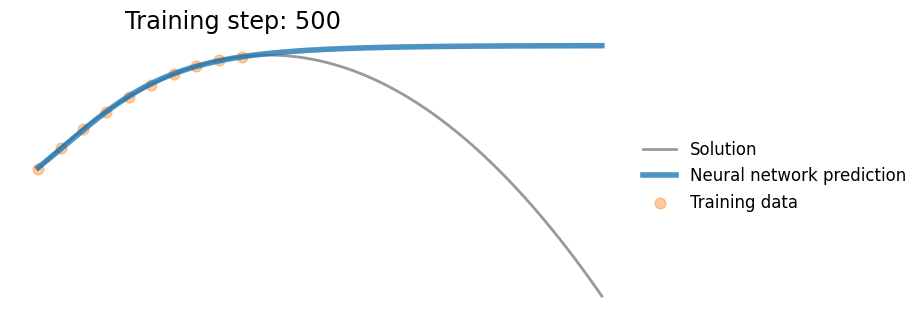

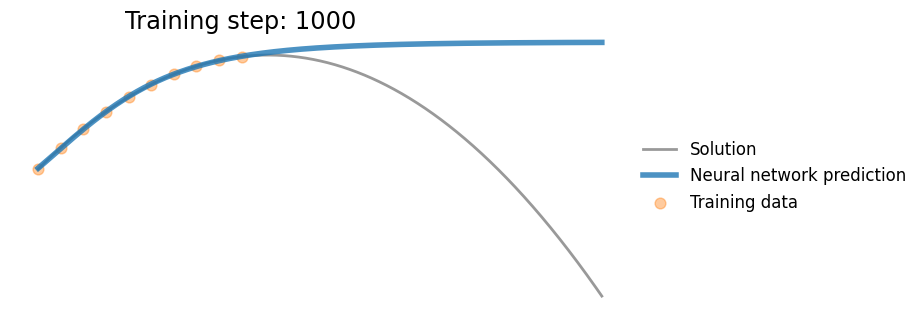

In [24]:
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1,1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)
x_data_tensor = torch.tensor(x_data, dtype=torch.float32).view(-1,1)
y_data_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1,1)

print(x_data_tensor)

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data_tensor)
    loss = torch.mean((yh-y_data_tensor)**2)
    loss.backward()
    optimizer.step()
    
    if (i+1) % 10 == 0: 
        
        yh = model(x_tensor).detach()
        
        plotPrettyResult(x_tensor,y_tensor,x_data_tensor,y_data_tensor,yh)
        
        file = "plots/plotsToGif/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")
            
saveGif("projectileSTD.gif", files, fps=20, loop=0)

Generate more data for training and comparing the solutions

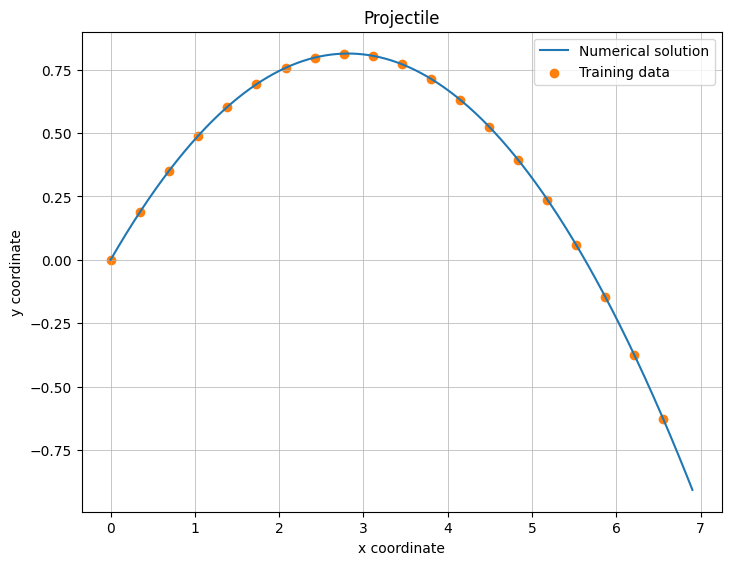

In [25]:
x_data2 = x[0:-1:50]
y_data2 = y[0:-1:50]
plotResult(x, y, x_data2, y_data2, 'Numerical solution', 'Training data', 'Projectile', 'plots/projectileTraining1.png')

tensor([[0.0000],
        [0.3463],
        [0.6925],
        [1.0386],
        [1.3846],
        [1.7304],
        [2.0761],
        [2.4217],
        [2.7671],
        [3.1125],
        [3.4577],
        [3.8028],
        [4.1478],
        [4.4926],
        [4.8374],
        [5.1820],
        [5.5264],
        [5.8708],
        [6.2150],
        [6.5590]])


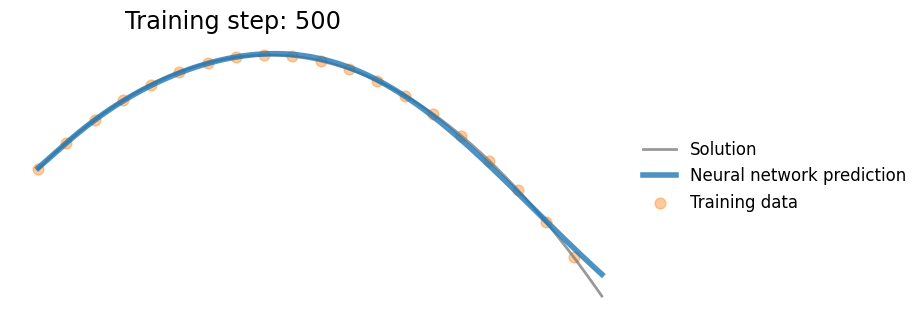

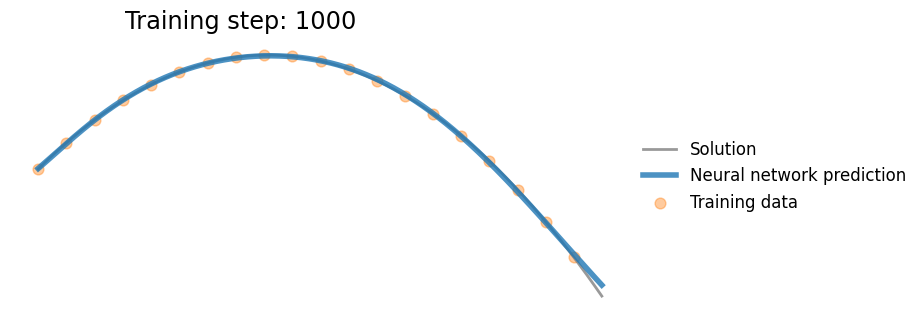

In [26]:
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1,1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)
x_data_tensor = torch.tensor(x_data2, dtype=torch.float32).view(-1,1)
y_data_tensor = torch.tensor(y_data2, dtype=torch.float32).view(-1,1)

print(x_data_tensor)

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data_tensor)
    loss = torch.mean((yh-y_data_tensor)**2)
    loss.backward()
    optimizer.step()
    
    if (i+1) % 10 == 0: 
        
        yh = model(x_tensor).detach()
        
        plotPrettyResult(x_tensor,y_tensor,x_data_tensor,y_data_tensor,yh)
        
        file = "plots/plotsToGif/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")
            
saveGif("projectileSTD2.gif", files, fps=20, loop=0)

### Using PINN

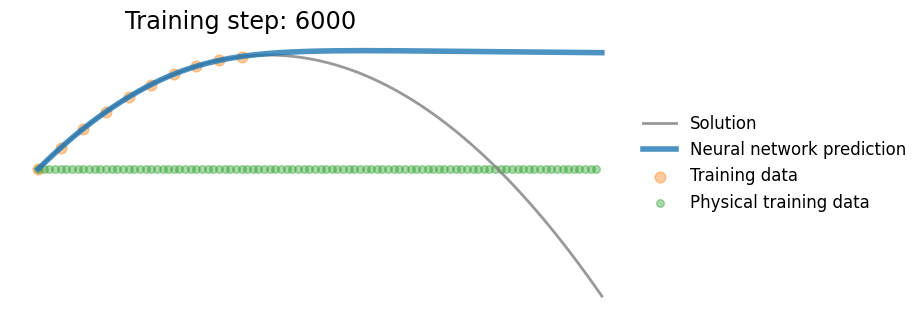

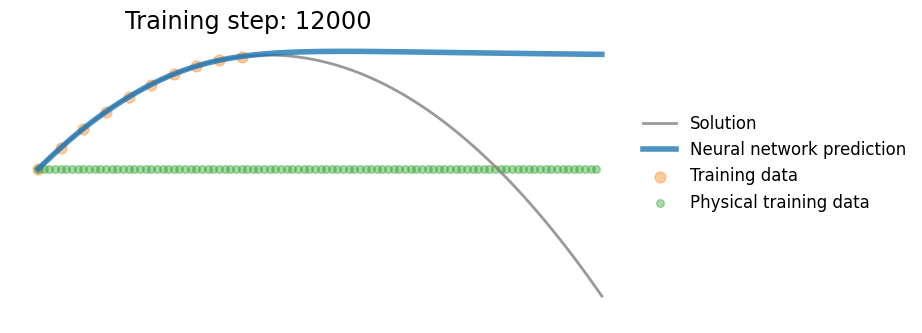

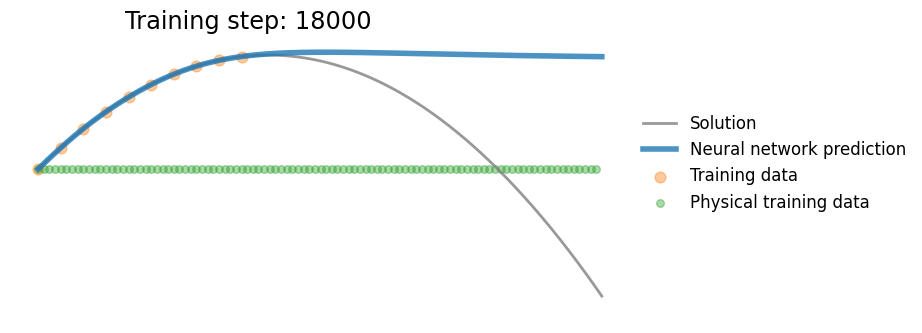

In [27]:
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1,1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)
x_data_tensor = torch.tensor(x_data, dtype=torch.float32).view(-1,1)
y_data_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1,1)

x_physics = torch.tensor(x[0:-1:10], dtype=torch.float32).view(-1,1).view(-1,1).requires_grad_(True)

mu = 0.001

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(20000):
    optimizer.zero_grad()
    yh = model(x_data_tensor)
    loss1 = torch.mean((yh-y_data_tensor)**2)

    # Calcula o "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = -mu*torch.abs(dx)*dx - dx2 # utiliza as derivadas de x para simular a solução de x a partir da equação diferencial
    loss2 = (1e-4)*torch.mean(physics**2)
    
    
    loss = loss1 + loss2

    loss.backward()
    optimizer.step()
    
    if (i+1) % 150 == 0: 
        
        yh = model(x_tensor).detach()
        xp = x_physics.detach()
        
        plotPrettyResult(x,y,x_data,y_data,yh,xp)
        
        file = "plots/plotsToGif/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
saveGif("projectilePINN.gif", files, fps=20, loop=0)

In [ ]:
@tf.function
def train(t_train, s_train, t_phys):
    # Data loss
    
    # predict displacement
    s_train_hat = net.predict(t_train)
    # MSE loss between training data and predictions
    data_loss = tf.math.reduce_mean(
        tf.math.square(s_train - s_train_hat)
    )
    # Physics loss
    
    # predict displacement
    s_phys_hat = net.predict(t_phys)
    # split into individual x and y components
    s_x = s_phys_hat[:, 0]
    s_y = s_phys_hat[:, 1]
    # take the gradients to get predicted velocity and acceleration
    v_x = tf.gradients(s_x, t_phys)[0]
    v_y = tf.gradients(s_y, t_phys)[0]
    a_x = tf.gradients(v_x, t_phys)[0]
    a_y = tf.gradients(v_y, t_phys)[0]
    # combine individual x and y components into velocity and
    # acceleration vectors
    v = tf.concat([v_x, v_y], axis=1)
    a = tf.concat([a_x, a_y], axis=1)
    # as acceleration is the known equation, this is what we want to
    # perform gradient descent on.
    # therefore, prevent any gradients flowing through the higher
    # order (velocity) terms
    v = tf.stop_gradient(v)
    # define speed (velocity norm, the ||v|| in the equation) and
    # gravity vector for physics equation
    speed = tf.norm(v, axis=1, keepdims=True)
    g = [[0.0, 9.81]]
    # MSE between known physics equation and network gradients
    phys_loss = tf.math.reduce_mean(
        tf.math.square(-mu * speed * v - g - a)
    )
    # Total loss
    
    loss = data_weight * data_loss + phys_weight * phys_loss
    
    # Gradient step
    
    # minimise the combined loss with respect to both the neural
    # network parameters and the unknown physics variable, mu
    gradients = tf.gradients(loss, net.train_vars + [mu])
    optimiser.apply_gradients(zip(gradients, net.train_vars + [mu]))